In [167]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [168]:
df = pd.read_csv("../data/merged_data_cleaned.csv", low_memory=False)
target = pd.read_csv('../data/target.csv')

In [169]:
# Rename target["csfractures"] to target["csi"]
target.rename(columns={"CSFractures": "csi"}, inplace=True)

In [170]:
target

,StudySubjectID,csi
0,110001,True
1,110002,True
2,110003,True
3,110004,True
4,110005,False
...,...,...
3309,1743310,False
3310,1743311,False
3311,1743312,False
3312,1743313,False


In [171]:
def site_train_val_test_split(df, target_df, val_size=0.2, test_size=0.2, random_state=42):
    """Split the data into train, validation, and test sets based on the SITE column.

    Args:
        df (pd.DataFrame): The input data.
        target_df (pd.DataFrame): The target data.
        val_size (float): The proportion of the data to include in the validation set.
        test_size (float): The proportion of the data to include in the test set.
        random_state (int): The random seed to use for reproducibility.
    
    Returns:
        tuple: A tuple containing the train, validation, and test sets for the input and target data.
    
    """

    # Extract number of unique sites
    n_sites = df.site.nunique()
    
    # Set random seed
    np.random.seed(random_state)
    
    # Select validation sites randomly
    val_sites = np.random.choice(df.site.unique(), size=int(n_sites * val_size), replace=False)
    
    # Select test sites randomly from remaining sites
    remaining_sites = df.site.unique()[~np.isin(df.site.unique(), val_sites)]
    test_sites = np.random.choice(remaining_sites, size=int(n_sites * test_size), replace=False)
    
    # Split the data
    val_df = df[df.site.isin(val_sites)]
    test_df = df[df.site.isin(test_sites)]
    train_df = df[~df.site.isin(np.concatenate((val_sites, test_sites)))]
    
    # Split the target
    val_target = target_df[df.site.isin(val_sites)]
    test_target = target_df[df.site.isin(test_sites)]
    train_target = target_df[~df.site.isin(np.concatenate((val_sites, test_sites)))]

    # Shuffle the data
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    val_df = val_df.sample(frac=1, random_state=random_state+1).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=random_state+2).reset_index(drop=True)
    
    # Drop columns
    if "site" in train_df.columns:
        train_df = train_df.drop(columns=["site"])
        val_df = val_df.drop(columns=["site"])
        test_df = test_df.drop(columns=["site"])

    if "caseid" in train_df.columns:
        train_df = train_df.drop(columns=["caseid"])
        val_df = val_df.drop(columns=["caseid"])
        test_df = test_df.drop(columns=["caseid"])

    if "studysubjectid" in train_df.columns:
        train_df = train_df.drop(columns=["studysubjectid"])
        val_df = val_df.drop(columns=["studysubjectid"])
        test_df = test_df.drop(columns=["studysubjectid"])
    
    return train_df, val_df, test_df, train_target, val_target, test_target

In [191]:
data = df
target_data = target

def preprocess_and_merge(data, target_data):
    data.columns = data.columns.str.lower()

    # merge with target data
    merged_data = data.merge(target_data, how='inner', left_on='studysubjectid', right_on='StudySubjectID')

    # drop duplicate columns
    merged_data = merged_data.drop(columns=['StudySubjectID'], axis=1)

    # convert bool to int
    merged_data['csi'] = merged_data['csi'].astype(int)

    # drop injurydatetime cuz it's all NaN
    merged_data = merged_data.drop(columns=['injurydatetime'], axis=1)

    return merged_data

In [39]:
# Metris are F1 score, precision, recall, accuracy, AUC, and confusion matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, balanced_accuracy_score

def print_metrics(y_true, y_pred):
    metrics = {
        'F1 score': f1_score(y_true, y_pred, average='weighted'),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'Accuracy': balanced_accuracy_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_pred)
    }
    print('Metrics:')
    for metric, value in metrics.items():
        print(f'{metric}: {value}')

    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))
    return metrics

In [40]:
# Define metric for training as balanced F1 score
from sklearn.metrics import make_scorer

balanced_f1 = make_scorer(f1_score, pos_label=1, average='weighted')

In [64]:
# SVM

In [166]:
processed_data = preprocess_and_merge(data, target_data)
X = processed_data.drop(columns=['csi'], axis=1)
y = processed_data['csi']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(['site', 'caseid', 'studysubjectid'])
cat_cols = X.select_dtypes(include=['object']).columns

X_train, X_val, X_test, y_train, y_val, y_test = site_train_val_test_split(X, y, random_state=42)

# impute and scale columns
imputer_num = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train_num = scaler.fit_transform(imputer_num.fit_transform(X_train[num_cols]))
X_val_num = scaler.transform(imputer_num.transform(X_val[num_cols]))
X_test_num = scaler.transform(imputer_num.transform(X_test[num_cols]))

imputer_cat = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(imputer_cat.fit_transform(X_train[cat_cols]))
X_val_cat = encoder.transform(imputer_cat.transform(X_val[cat_cols]))
X_test_cat = encoder.transform(imputer_cat.transform(X_test[cat_cols]))


X_train_preprocessed = np.hstack([X_train_num, X_train_cat])
X_val_preprocessed = np.hstack([X_val_num, X_val_cat])
X_test_preprocessed = np.hstack([X_test_num, X_test_cat])

model = SVC(kernel='rbf', probability=True, random_state=42)
model_name = "Support Vector Machine"

model.fit(X_train_preprocessed, y_train)

train_pred = model.predict(X_train_preprocessed)
val_pred = model.predict(X_val_preprocessed)
test_pred = model.predict(X_test_preprocessed)

# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(y_train, train_pred)

# Print the metrics for the validation set
print('Validation set:')
val_metrics = print_metrics(y_val, val_pred)

# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(y_test, test_pred)

Train set:
Metrics:
F1 score: 0.8650577128939079
Precision: 0.9156359214995172
Recall: 0.9069575957184026
Accuracy: 0.5129310344827587
AUC: 0.5129310344827587
Confusion matrix:
[[2197    0]
 [ 226    6]]
Validation set:
Metrics:
F1 score: 0.8512414800389484
Precision: 0.8082701553254439
Recall: 0.8990384615384616
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[374   0]
 [ 42   0]]
Test set:
Metrics:
F1 score: 0.8492417527131597
Precision: 0.80578375257432
Recall: 0.8976545842217484
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[421   0]
 [ 48   0]]


/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [174]:
def svm_model(X_train, y_train, kernel='rbf', C=100, gamma='scale'):
    model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    return model

In [109]:
def testing_model(model, X_test, y_test):
    test_pred = model.predict(X_test)
    print('Test set:')
    test_metrics = print_metrics(y_test, test_pred)

In [179]:
def plot_roc(model, X, y_pred, model_name='', path='../plots/jacob.png'):
    y_pred_vals = model.decision_function(X)
    
    # roc curve
    fpr, tpr, _ = roc_curve(y_pred, y_pred_vals)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    plt.title(f'ROC Curve using {model_name} SVM')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, dpi=300)
    plt.show()

In [180]:
processed_data = preprocess_and_merge(data, target_data)
X = processed_data.drop(columns=['csi'], axis=1)
y = processed_data['csi']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(['site', 'caseid', 'studysubjectid'])
cat_cols = X.select_dtypes(include=['object']).columns

X_train, X_val, X_test, y_train, y_val, y_test = site_train_val_test_split(X, y, random_state=42)

# impute and scale columns
imputer_num = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train_num = scaler.fit_transform(imputer_num.fit_transform(X_train[num_cols]))
X_val_num = scaler.transform(imputer_num.transform(X_val[num_cols]))
X_test_num = scaler.transform(imputer_num.transform(X_test[num_cols]))

imputer_cat = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(imputer_cat.fit_transform(X_train[cat_cols]))
X_val_cat = encoder.transform(imputer_cat.transform(X_val[cat_cols]))
X_test_cat = encoder.transform(imputer_cat.transform(X_test[cat_cols]))


X_train_preprocessed = np.hstack([X_train_num, X_train_cat])
X_val_preprocessed = np.hstack([X_val_num, X_val_cat])
X_test_preprocessed = np.hstack([X_test_num, X_test_cat])

In [181]:
rbf_svm = svm_model(X_train_preprocessed, y_train, kernel='rbf', C=100, gamma=0.01)
poly_svm = svm_model(X_train_preprocessed, y_train, kernel='poly', C=100, gamma=0.01)
sigmoid_svm = svm_model(X_train_preprocessed, y_train, kernel='sigmoid', C=100, gamma=0.01)

In [182]:
testing_model(rbf_svm, X_test_preprocessed, y_test)

Test set:
Metrics:
F1 score: 0.8492417527131597
Precision: 0.80578375257432
Recall: 0.8976545842217484
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[421   0]
 [ 48   0]]


/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [183]:
testing_model(poly_svm, X_test_preprocessed, y_test)

Test set:
Metrics:
F1 score: 0.8319224407547096
Precision: 0.8025388666883182
Recall: 0.8635394456289979
Accuracy: 0.4809976247030879
AUC: 0.4809976247030879
Confusion matrix:
[[405  16]
 [ 48   0]]


In [184]:
testing_model(sigmoid_svm, X_test_preprocessed, y_test)

Test set:
Metrics:
F1 score: 0.6500797769485412
Precision: 0.8315730324608742
Recall: 0.5650319829424307
Accuracy: 0.5454522961203484
AUC: 0.5454522961203484
Confusion matrix:
[[240 181]
 [ 23  25]]


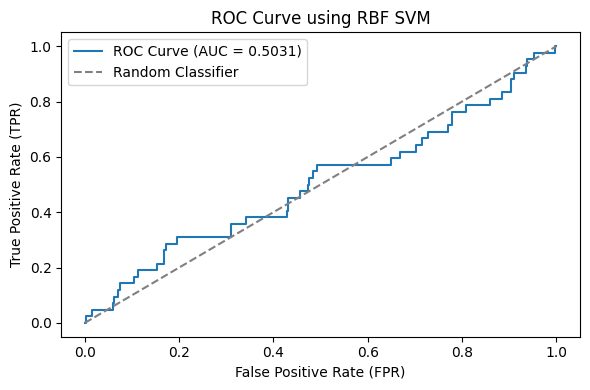

In [185]:
plot_roc(rbf_svm, X_val_preprocessed, y_val, model_name="RBF", path="../data/rbf_roc.png")

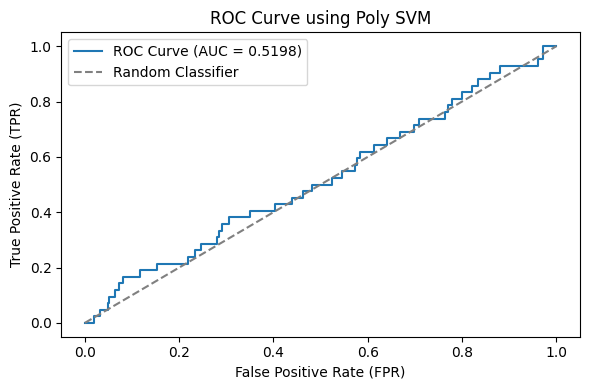

In [186]:
plot_roc(poly_svm, X_val_preprocessed, y_val, model_name="Poly", path="../data/poly_roc.png")

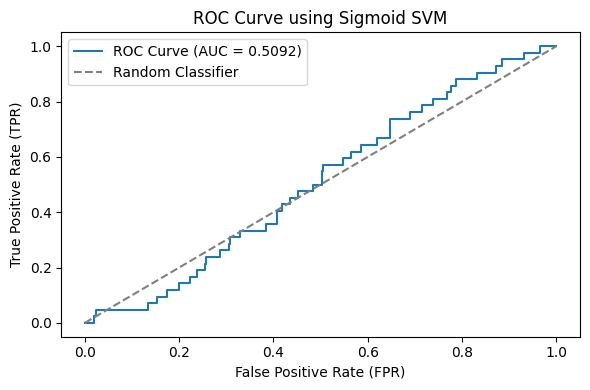

In [187]:
plot_roc(sigmoid_svm, X_val_preprocessed, y_val, model_name="Sigmoid", path="../data/sigmoid_roc.png")

In [188]:
processed_data = preprocess_and_merge(data, target_data)
X = processed_data.drop(columns=['csi'], axis=1)
y = processed_data['csi']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(['site', 'caseid', 'studysubjectid'])
cat_cols = X.select_dtypes(include=['object']).columns

X_train, X_val, X_test, y_train, y_val, y_test = site_train_val_test_split(X, y, random_state=42)

# impute and scale columns
imputer_num = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train_num = scaler.fit_transform(imputer_num.fit_transform(X_train[num_cols]))
X_val_num = scaler.transform(imputer_num.transform(X_val[num_cols]))
X_test_num = scaler.transform(imputer_num.transform(X_test[num_cols]))

imputer_cat = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(imputer_cat.fit_transform(X_train[cat_cols]))
X_val_cat = encoder.transform(imputer_cat.transform(X_val[cat_cols]))
X_test_cat = encoder.transform(imputer_cat.transform(X_test[cat_cols]))


X_train_preprocessed = np.hstack([X_train_num, X_train_cat])
X_val_preprocessed = np.hstack([X_val_num, X_val_cat])
X_test_preprocessed = np.hstack([X_test_num, X_test_cat])

model = SVC(kernel='rbf', gamma=0.01, C=100, probability=True, random_state=42, class_weight='balanced')
model_name = "Support Vector Machine"

model.fit(X_train_preprocessed, y_train)

train_pred = model.predict(X_train_preprocessed)
val_pred = model.predict(X_val_preprocessed)
test_pred = model.predict(X_test_preprocessed)

# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(y_train, train_pred)

# Print the metrics for the validation set
print('Validation set:')
val_metrics = print_metrics(y_val, val_pred)

# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(y_test, test_pred)

Train set:
Metrics:
F1 score: 1.0
Precision: 1.0
Recall: 1.0
Accuracy: 1.0
AUC: 1.0
Confusion matrix:
[[2197    0]
 [   0  232]]
Validation set:
Metrics:
F1 score: 0.8512414800389484
Precision: 0.8082701553254439
Recall: 0.8990384615384616
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[374   0]
 [ 42   0]]
Test set:
Metrics:
F1 score: 0.8492417527131597
Precision: 0.80578375257432
Recall: 0.8976545842217484
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[421   0]
 [ 48   0]]


/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


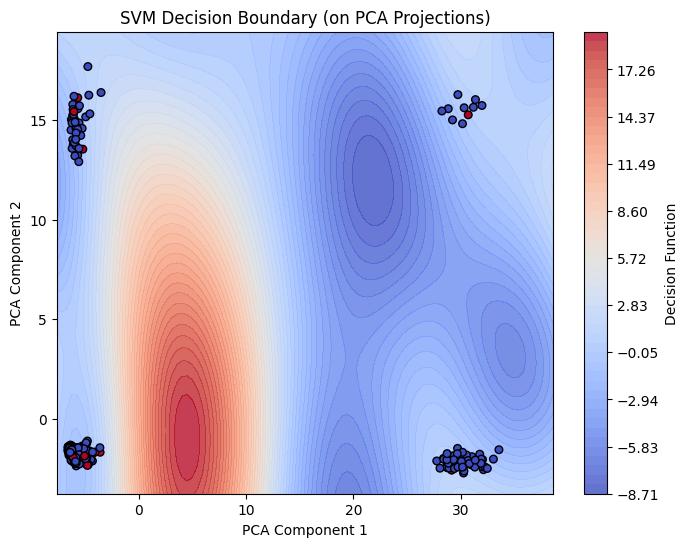

In [190]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(X_test_preprocessed)

svm_pca = SVC(kernel='rbf', C=100, gamma=0.01,class_weight='balanced', probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train)

# decision boundary
xx, yy = np.meshgrid(np.linspace(X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1, 100),
                     np.linspace(X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1, 100))
Z = svm_pca.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Decision Function')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', s=30)
plt.title('SVM Decision Boundary (on PCA Projections)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("../plots/svm_decision.png", dpi=300)
plt.show()

In [ ]:
svm_pca = SVC(kernel='rbf', C=100, gamma=0.01,class_weight='balanced', probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train)

In [158]:
test_pred = svm_pca.predict(X_test_pca)

# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(y_test, test_pred)

Test set:
Metrics:
F1 score: 0.7777420070428904
Precision: 0.8158764133207411
Recall: 0.746268656716418
Accuracy: 0.49873812351543945
AUC: 0.49873812351543945
Confusion matrix:
[[341  80]
 [ 39   9]]


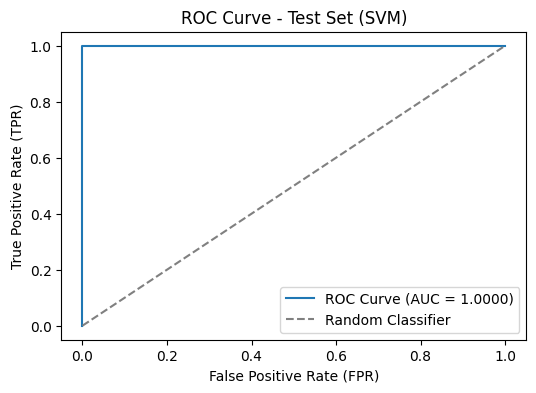

In [73]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_pred, test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('ROC Curve - Test Set (SVM)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()


In [69]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

svm = SVC(probability=True, class_weight='balanced', random_state=42)

# grid search on recall
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train)

print("Best hyperparams:", grid_search.best_params_)

best_svm = grid_search.best_estimator_
best_svm.fit(X_train_preprocessed, y_train)

train_pred = best_svm.predict(X_train_preprocessed)
val_pred = best_svm.predict(X_val_preprocessed)
test_pred = best_svm.predict(X_test_preprocessed)

# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(y_train, train_pred)

# Print the metrics for the validation set
print('Validation set:')
val_metrics = print_metrics(y_val, val_pred)

# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(y_test, test_pred)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Train set:
Metrics:
F1 score: 0.6929567479736051
Precision: 0.865301255788423
Recall: 0.6134211609715934
Accuracy: 0.6243819942554896
AUC: 0.6243819942554895
Confusion matrix:
[[1342  855]
 [  84  148]]
Validation set:
Metrics:
F1 score: 0.6645369614612517
Precision: 0.8030695266272189
Recall: 0.5817307692307693
Accuracy: 0.45034377387318564
AUC: 0.4503437738731856
Confusion matrix:
[[230 144]
 [ 30  12]]
Test set:
Metrics:
F1 score: 0.725053820769256
Precision: 0.81071148019302
Recall: 0.6652452025586354
Accuracy: 0.48129453681710216
AUC: 0.48129453681710205
Confusion matrix:
[[300 121]
 [ 36  12]]



Validation Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       374
           1       0.10      0.17      0.12        42

    accuracy                           0.76       416
   macro avg       0.50      0.50      0.49       416
weighted avg       0.82      0.76      0.79       416

Validation ROC AUC: 0.5266


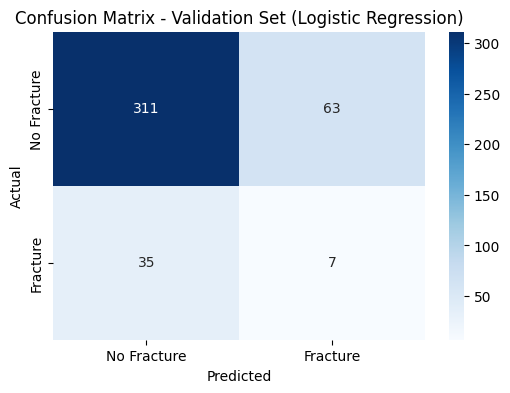


Test Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       421
           1       0.18      0.21      0.19        48

    accuracy                           0.82       469
   macro avg       0.54      0.55      0.54       469
weighted avg       0.83      0.82      0.83       469

Test ROC AUC: 0.5751


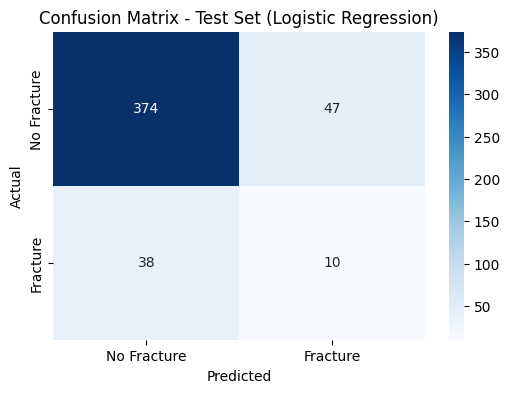


Validation Results for Random Forest:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       374
           1       0.00      0.00      0.00        42

    accuracy                           0.90       416
   macro avg       0.45      0.50      0.47       416
weighted avg       0.81      0.90      0.85       416

Validation ROC AUC: 0.4516


/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

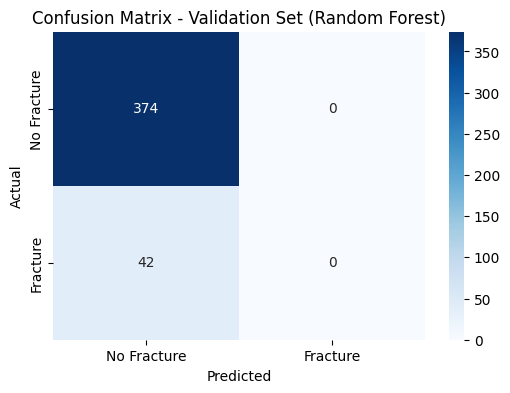


Test Results for Random Forest:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       421
           1       0.00      0.00      0.00        48

    accuracy                           0.90       469
   macro avg       0.45      0.50      0.47       469
weighted avg       0.81      0.90      0.85       469

Test ROC AUC: 0.4870


/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacob/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

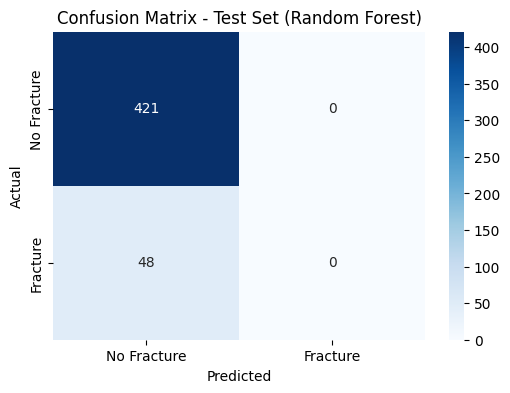


Validation Results for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       374
           1       0.00      0.00      0.00        42

    accuracy                           0.89       416
   macro avg       0.45      0.50      0.47       416
weighted avg       0.81      0.89      0.85       416

Validation ROC AUC: 0.4484


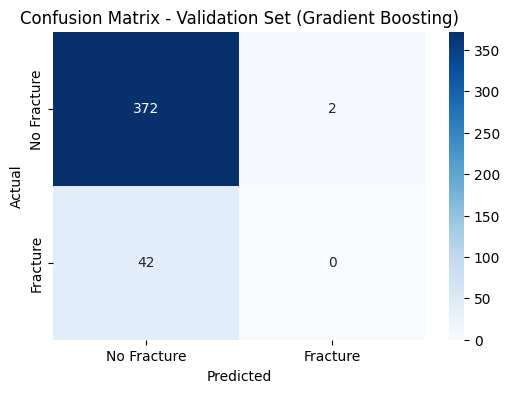


Test Results for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       421
           1       0.00      0.00      0.00        48

    accuracy                           0.89       469
   macro avg       0.45      0.50      0.47       469
weighted avg       0.81      0.89      0.85       469

Test ROC AUC: 0.5389


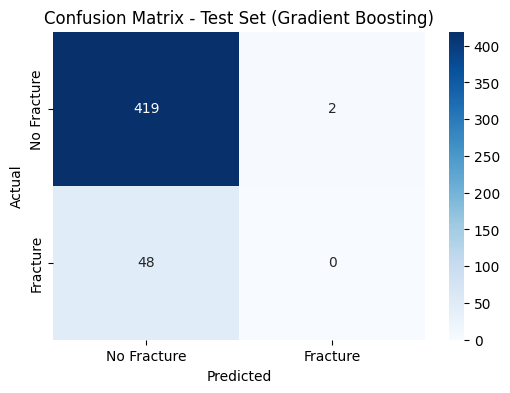


Validation Results for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       374
           1       0.09      0.12      0.11        42

    accuracy                           0.80       416
   macro avg       0.50      0.50      0.49       416
weighted avg       0.82      0.80      0.81       416

Validation ROC AUC: 0.5367


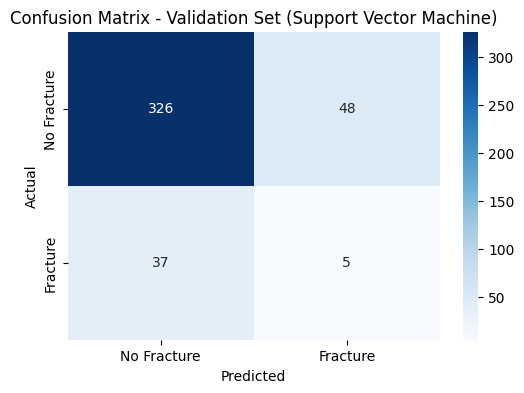


Test Results for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       421
           1       0.13      0.15      0.14        48

    accuracy                           0.82       469
   macro avg       0.52      0.52      0.52       469
weighted avg       0.82      0.82      0.82       469

Test ROC AUC: 0.5620


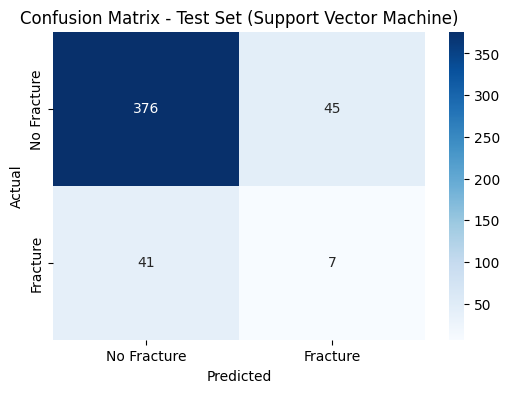

In [192]:
processed_data = preprocess_and_merge(data, target_data)
X = processed_data.drop(columns=['csi'], axis=1)
y = processed_data['csi']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(['site', 'caseid', 'studysubjectid'])
cat_cols = X.select_dtypes(include=['object']).columns

X_train, X_val, X_test, y_train, y_val, y_test = site_train_val_test_split(X, y, random_state=42)

# impute and scale columns
imputer_num = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train_num = scaler.fit_transform(imputer_num.fit_transform(X_train[num_cols]))
X_val_num = scaler.transform(imputer_num.transform(X_val[num_cols]))
X_test_num = scaler.transform(imputer_num.transform(X_test[num_cols]))

imputer_cat = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(imputer_cat.fit_transform(X_train[cat_cols]))
X_val_cat = encoder.transform(imputer_cat.transform(X_val[cat_cols]))
X_test_cat = encoder.transform(imputer_cat.transform(X_test[cat_cols]))


X_train_preprocessed = np.hstack([X_train_num, X_train_cat])
X_val_preprocessed = np.hstack([X_val_num, X_val_cat])
X_test_preprocessed = np.hstack([X_test_num, X_test_cat])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, class_weight='balanced', random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_preprocessed, y_train)

    # val set
    y_val_pred = model.predict(X_val_preprocessed)
    y_val_pred_proba = model.predict_proba(X_val_preprocessed)[:, 1] if hasattr(model, "predict_proba") else None
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    val_auc = roc_auc_score(y_val, y_val_pred_proba) if y_val_pred_proba is not None else None
    val_cm = confusion_matrix(y_val, y_val_pred)

    # val results
    print(f"\nValidation Results for {model_name}:")
    print(classification_report(y_val, y_val_pred))
    if val_auc is not None:
        print(f"Validation ROC AUC: {val_auc:.4f}")

    # val confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fracture', 'Fracture'], yticklabels=['No Fracture', 'Fracture'])
    plt.title(f'Confusion Matrix - Validation Set ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # test set
    y_test_pred = model.predict(X_test_preprocessed)
    y_test_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1] if hasattr(model, "predict_proba") else None

    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_auc = roc_auc_score(y_test, y_test_pred_proba) if y_test_pred_proba is not None else None
    test_cm = confusion_matrix(y_test, y_test_pred)

    # test results
    print(f"\nTest Results for {model_name}:")
    print(classification_report(y_test, y_test_pred))
    if test_auc is not None:
        print(f"Test ROC AUC: {test_auc:.4f}")

    # test confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fracture', 'Fracture'], yticklabels=['No Fracture', 'Fracture'])
    plt.title(f'Confusion Matrix - Test Set ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [64]:
df.columns

Index(['site', 'caseid', 'controltype', 'studysubjectid', 'arrivaldate',
       'arrivaltime', 'arrivaltimend', 'modearrival', 'receivedintransfer',
       'dxcspineinjury',
       ...
       'cspinesignalchange', 'signalchangelevelc1', 'signalchangelevelc2',
       'signalchangelevelc3', 'signalchangelevelc4', 'signalchangelevelc5',
       'signalchangelevelc6', 'signalchangelevelc7',
       'cordinjurynoradiographic', 'injurydatetime'],
      dtype='object', length=620)

In [68]:
df.select_dtypes(include=['object']).columns

Index(['controltype', 'arrivaldate', 'arrivaltime', 'modearrival',
       'locevalphysician', 'hxloc', 'totalgcsavailable', 'totalgcs',
       'pttender', 'limitedrangemotion', 'otherinjuries', 'minorinjuries',
       'ptparesthesias', 'ptsensoryloss', 'intubatedss', 'eddisposition',
       'emsarrivaldate', 'emsarrivaltime', 'hxloc_dup',
       'sectiongcsavailable_dup', 'totalgcsavailable_dup', 'avpudetails_dup',
       'avpumental_dup', 'avpumentaltxt_dup', 'avpumentaltxtcat_dup',
       'ptcomppain_dup', 'ptcomppainneckmove_dup', 'pttender_dup',
       'limitedrangemotion_dup', 'otherinjuries_dup', 'minorinjurieslist',
       'ptparesthesias_dup', 'ptsensoryloss_dup', 'ptextremityweakness_dup',
       'otherneurodeficit_dup', 'otherneurodeficitdesc_dup',
       'otherneurodeficitdesccat_dup', 'cervicalspineprecautions',
       'medsgivenothertxt_dup', 'intubatedbyems',
       'pttenderneckothertxtcat_dup', 'ptambulatorypriorarrival_dup',
       'pttenderneckothertxt_dup', 'intervfo

In [71]:
from collections import Counter

In [72]:
Counter(df.c6_7sbligfdub)

Counter({'-1': 3306, 'U': 7, 'B': 1})

In [65]:
processed_data.shape

(3314, 620)

In [66]:
X_train.shape

(2651, 3952)

In [67]:
X_train

,site,caseid,studysubjectid,arrivaltimend,receivedintransfer,dxcspineinjury,ptambulatorypriorarrival,cervicalspineimmobilization,cervicalspineintervcc,cervicalspineintervrlb,...,c1_2sbligfdub_U,c2_3sbligfdub_B,c2_3sbligfdub_U,c3_4sbligfdub_B,c3_4sbligfdub_U,c4_5sbligfdub_B,c5_6sbligfdub_B,c5_6sbligfdub_U,c6_7sbligfdub_B,c6_7sbligfdub_U
68,1,110012,130075,0,0,0,0,1.000000,1,1,...,False,False,False,False,False,False,False,False,False,False
98,1,110017,120046,0,0,0,0,1.000000,1,1,...,False,False,False,False,False,False,False,False,False,False
1381,8,811161,831251,0,0,0,0,1.000000,1,1,...,False,False,False,False,False,False,False,False,False,False
605,4,410485,420511,0,0,0,0,1.000000,1,1,...,False,False,False,False,False,False,False,False,False,False
1630,10,1011610,1041818,1,0,0,1,0.000000,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2673,15,1512515,1532662,0,0,0,0,1.000000,1,1,...,False,False,False,False,False,False,False,False,False,False
2717,15,1512522,1522551,0,0,0,0,1.000000,1,1,...,False,False,False,False,False,False,False,False,False,False
1440,8,811171,841375,0,1,1,0,0.761111,0,0,...,False,False,False,False,False,False,False,False,False,False
1487,9,911474,911474,0,1,1,2,1.000000,1,0,...,False,False,False,False,False,False,False,False,False,False


In [58]:
X_train_selected.shape

(2651, 429)

In [59]:
data_merged

,site,caseid,controltype,studysubjectid,arrivaldate,arrivaltime,arrivaltimend,modearrival,receivedintransfer,dxcspineinjury,...,signalchangelevelc1,signalchangelevelc2,signalchangelevelc3,signalchangelevelc4,signalchangelevelc5,signalchangelevelc6,signalchangelevelc7,cordinjurynoradiographic,injurydatetime,CSFractures
0,1,110001,case,110001,1/1/2000,22:16,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,1
1,1,110001,ems,120027,1/1/2000,17:45,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
2,1,110001,ems,120032,1/1/2000,19:58,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
3,1,110001,moi,130058,1/1/2000,13:20,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
4,1,110001,moi,130072,1/1/2000,16:38,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,17,1713132,ems,1723178,1/1/2000,20:37,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
3310,17,1713132,moi,1733196,1/1/2000,18:05,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
3311,17,1713132,moi,1733220,1/1/2000,17:05,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
3312,17,1713132,ran,1743311,1/1/2000,15:50,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,NaN,0
